In [1]:
import numpy as np
import pandas as pd
import collections
import itertools
import pickle
import os
from scipy.sparse import csr_matrix

#import gensim
#from gensim.models import Word2Vec

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns

## Preprocessing

In [5]:
# load data (166 econ students)
econ = pd.read_csv('../00_data/2013-2020/econ.csv')
econ.head(3) 

Calculation ID  Subject Catalog                      Descr Grade  \
0      15839.4125  ITALIAN     335      MAJOR ITALIAN AUTHORS    A-   
1      15839.4125  ITALIAN     390  ITALIAN LIT AND CIV (TOP)     A   
2      15839.4125  ITALIAN     333    INTRO TO ITALIAN LIT II     A   

         Term Descr         Major 1 Minor 1 Minor 2  Minor 3 Certificate 1  \
0    2012 Fall Term  Economics (BS)     NaN     NaN      NaN           NaN   
1    2012 Fall Term  Economics (BS)     NaN     NaN      NaN           NaN   
2  2013 Spring Term  Economics (BS)     NaN     NaN      NaN           NaN   

  Certificate 2            Secondary 1  Secondary 2  Grad Year  \
0           NaN  Italian Studies (AB2)          NaN     2014.0   
1           NaN  Italian Studies (AB2)          NaN     2014.0   
2           NaN  Italian Studies (AB2)          NaN     2014.0   

   Enrollment Start  Term Year Semester Term              Class Year  \
0            2012.0     2012.0     Fall Term    First Year Fall Term   
1            2012.0     2012.0     Fall Term    First Year Fall Term   
2            2012.0     2013.0   Spring Term  First Year Spring Term   

   Number Grade  
0           3.7  
1           4.0  
2           4.0

In [25]:
# create index for class year
class_year_dic = {1:'first year fall term', 2: 'first year spring term', 
                  3:'second year fall term', 4: 'second year spring term',
                  5: 'third year fall term', 6: 'third year spring term',
                  7: 'fourth year fall term', 8: 'fourth year spring term'}
yr_to_idx = {v:k for k, v in class_year_dic.items()}
term_dic = {0: 'First', 2:'Second', 4:'Third', 6:'Fourth'}

def preprocess(data):
    '''
    Preprocess the raw data input and return the dataframe in standardized format and user/item dictionaries obtained from it
    '''
    # columns of interest
    cols = ['Calculation ID', 'Subject', 'Catalog', 'Descr', 'Number Grade', 'Major 1', 'Minor 1', 'Minor 2', 'Class Year']
    df = data[cols]
    df.columns = [str.lower(col.replace(' ', '_')) for col in df.columns]

    # lowercase string cols to use
    for col in df.columns:
        if isinstance(df.loc[0, col], str):
            df[col] = df[col].str.lower() 

    # exclude summer terms which is na in class_year
    df = df[df['class_year'].notna()]
    # map class year to corresponding index number
    df['class_year'] = df['class_year'].map(yr_to_idx)


    # create index for courses (item dic)
    idx_course = {idx: descr for idx, descr in enumerate(df['descr'].unique())} 
    # map course descriptions to indices
    course_idx = {v:k for k,v in idx_course.items()}
    df['course_idx'] = df['descr'].map(course_idx)
    

    # create index for students (user dic)
    # map str(calculation_id)_to_idx
    user_to_idx = {str(calc_id): idx for idx, calc_id in enumerate(df['calculation_id'].unique())}

    # normalize grade for each student
    df['grade_normed'] = df['number_grade'] / df.groupby('calculation_id')['number_grade'].transform('sum')

    return df, idx_course, user_to_idx

df, idx_course, user_dic = preprocess(econ)
print('number of students=', len(user_dic))
print('number of classes=', len(idx_course))
print()

df.info()

number of students= 1467
number of classes= 2191

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33947 entries, 0 to 35198
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   calculation_id  33947 non-null  float64
 1   subject         33947 non-null  object 
 2   catalog         33947 non-null  object 
 3   descr           33947 non-null  object 
 4   number_grade    33947 non-null  float64
 5   major_1         33947 non-null  object 
 6   minor_1         15988 non-null  object 
 7   minor_2         2074 non-null   object 
 8   class_year      33762 non-null  float64
 9   course_idx      33947 non-null  int64  
 10  grade_normed    33947 non-null  float64
dtypes: float64(4), int64(1), object(6)
memory usage: 3.1+ MB


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Create User Matrix

In [7]:
def build_user_matrix(df):
    user = df[['calculation_id', 'major_1', 'minor_1', 'minor_2']]

    minor1 = user.groupby('calculation_id')['minor_1'].apply(lambda x: list(set(x))[0]).reset_index()
    minor2 = user.groupby('calculation_id')['minor_2'].apply(lambda x: list(set(x))[0]).reset_index()

    major = user.groupby('calculation_id')['major_1'].apply(lambda x: list(set(x))[0]).reset_index()
    
    minors = pd.merge(minor1, minor2, on='calculation_id', how='inner')
    user = pd.merge(major, minors, on='calculation_id', how='inner')

    # dummify categorical features
    user_transformed = pd.get_dummies(user, columns=['major_1', 'minor_1', 'minor_2'])
    #user_csr = csr_matrix(user_transformed.drop('calculation_id', axis=1).values)
    return user_transformed

In [8]:
user_transformed = build_user_matrix(df)
user_transformed.head(3)

calculation_id  major_1_economics (bs)  \
0      15839.4125                       1   
1      19857.1625                       1   
2      19920.5375                       1   

   minor_1_African & African Am St (MIN)  minor_1_Art History (MIN)  \
0                                      0                          0   
1                                      0                          0   
2                                      0                          0   

   minor_1_Asian & Mid East Studies (MIN)  minor_1_Biology (MIN)  \
0                                       0                      0   
1                                       0                      0   
2                                       1                      0   

   minor_1_Chemistry (MIN)  minor_1_Classical Civilizations (MIN)  \
0                        0                                      0   
1                        0                                      0   
2                        0                                      0   

   minor_1_Computatnl Bio/Bioinform (MIN)  minor_1_Computer Science (MIN)  \
0                                       0                               0   
1                                       0                               0   
2                                       0                               0   

   ...  minor_2_ Mathematics (MIN)  minor_2_ Philosophy (MIN)  \
0  ...                           0                          0   
1  ...                           0                          0   
2  ...                           0                          0   

   minor_2_ Political Science (MIN)  minor_2_ Psychology (MIN)  \
0                                 0                          0   
1                                 0                          0   
2                                 0                          0   

   minor_2_ Russian Language/Cult (MIN)  minor_2_ Sociology (MIN)  \
0                                     0                         0   
1                                     0                         0   
2                                     0                         0   

   minor_2_ Spanish (MIN)  minor_2_ Statistical Science (MIN)  \
0                       0                                   0   
1                       0                                   0   
2                       0                                   0   

   minor_2_ Visual and Media Studies (MIN)  minor_2_ Women's Studies (MIN)  
0                                        0                               0  
1                                        0                               0  
2                                        0                               0  

[3 rows x 63 columns]

## User Clustering

In [9]:
def elbow_k(matrix, col):
    # obtain the optimal number of clusters from elbow plot
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=123)
        kmeans.fit(matrix.drop(col, axis=1).values)
        wcss.append(kmeans.inertia_)
    plt.plot(range(1, 11), wcss)
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

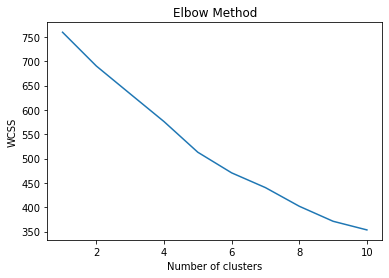

In [10]:
elbow_k(user_transformed, 'calculation_id')

In [11]:
def cluster(matrix, col):
    kmeans = KMeans(n_clusters=10, init='k-means++', max_iter=300, n_init=10, random_state=123)
    pred_y = kmeans.fit_predict(matrix.drop(col, axis=1).values)
    matrix['cluster_num'] = pred_y

    clustered = matrix[[col, 'cluster_num']].merge(df, on=col, how='inner')
    return clustered

In [12]:
user_clustered = cluster(user_transformed, 'calculation_id')
user_clustered.head()

calculation_id  cluster_num  subject catalog  number_grade         major_1  \
0      15839.4125            0  italian     335           3.7  economics (bs)   
1      15839.4125            0  italian     390           4.0  economics (bs)   
2      15839.4125            0  italian     333           4.0  economics (bs)   
3      15839.4125            0  italian     301           4.0  economics (bs)   
4      15839.4125            0  italian    490s           4.0  economics (bs)   

  minor_1 minor_2  class_year  course_idx  grade_normed  
0     NaN     NaN         1.0           0      0.111111  
1     NaN     NaN         1.0           1      0.120120  
2     NaN     NaN         2.0           2      0.120120  
3     NaN     NaN         3.0           3      0.120120  
4     NaN     NaN         3.0           4      0.120120

In [13]:
# plot the distribution of col within a cluster
def dist_within_cluster(clustered, col, k):
    cluster_k = clustered[clustered['cluster_num'] == k]
    dist =(cluster_k[col].value_counts()/clustered[col].value_counts()).reset_index().sort_values(col, ascending=False)
    dist[col].plot(kind='pie', labels=dist['index'])
    plt.title(f'cluster_num_{k}')
    #return dist

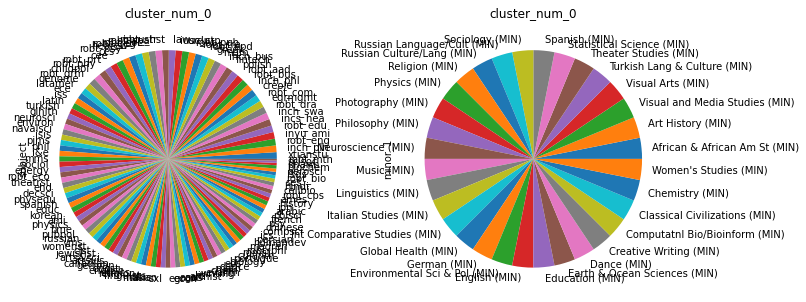

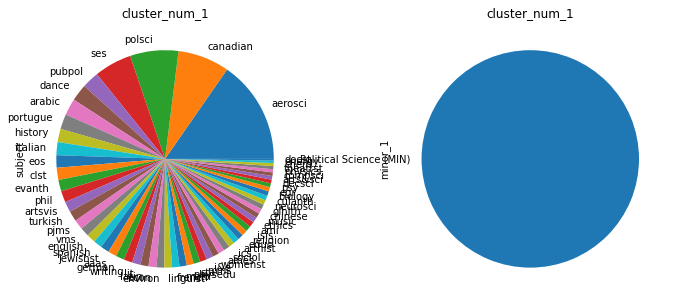

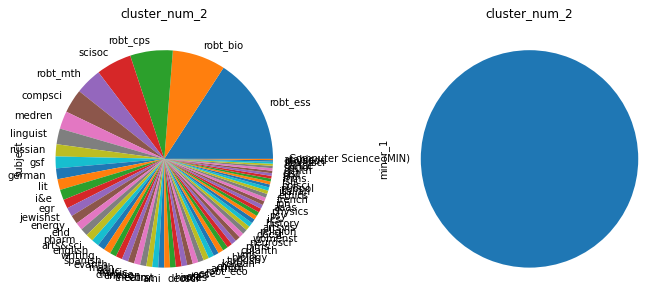

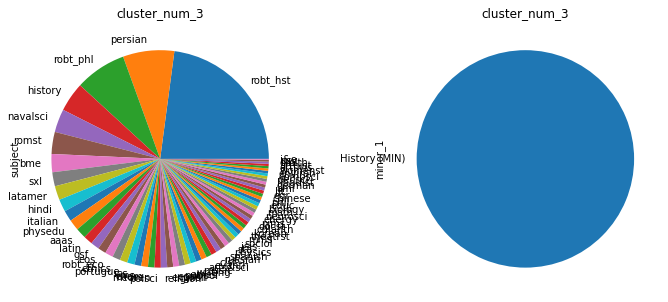

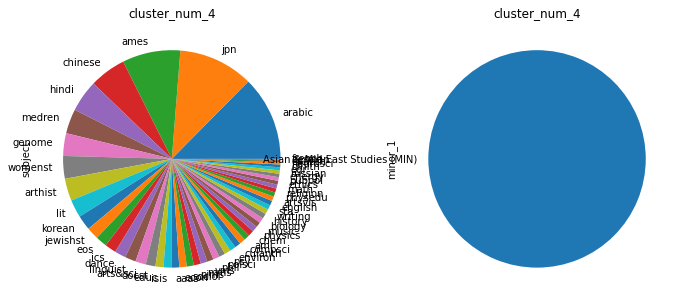

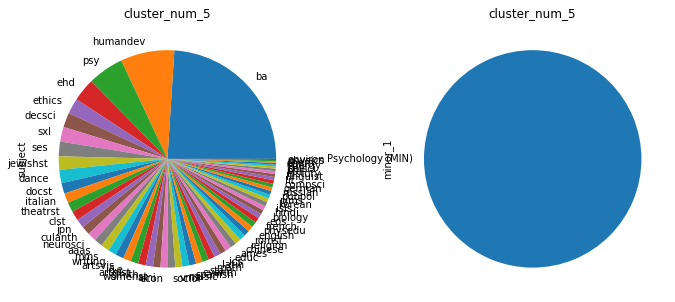

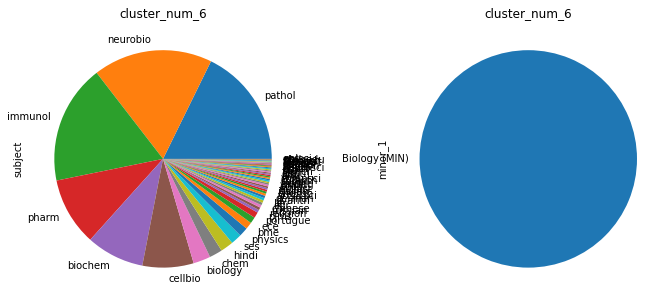

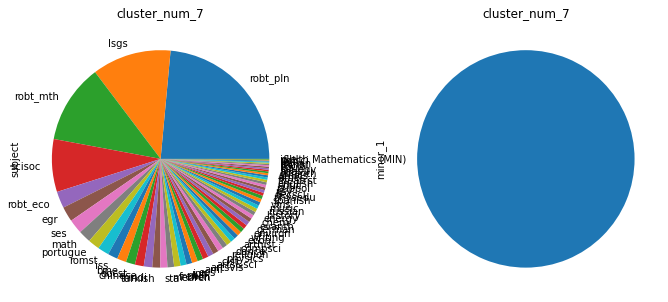

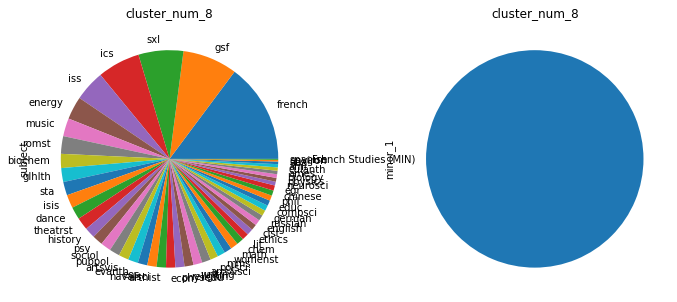

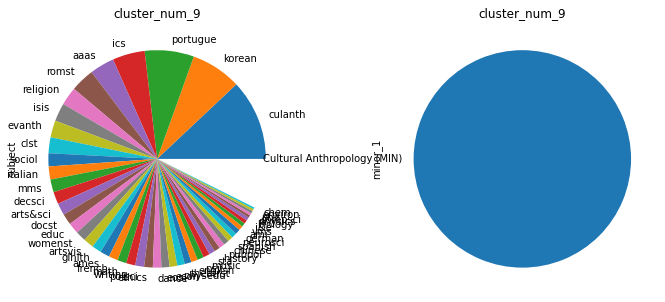

In [14]:
# check subject and maj/minor distribution within a cluster
for i in range(10):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    dist_within_cluster(user_clustered, 'subject', i)
    
    plt.subplot(1,2,2)
    dist_within_cluster(user_clustered, 'minor_1', i)
    
    plt.show()

In [17]:
# for k,v in descr_to_subject.items():
#     if 'robt' in v:
#         print(k, ':',v)

## Course matrix

In [18]:
def build_course_matrix(df):
    '''
    Returns item feature matrix course_matrix
    '''
    course = df[['course_idx', 'class_year', 'subject']]

    # obtain availability of class year for each class by dummify class year and subject as categorical variable
    course_transformed = pd.get_dummies(course, columns=['class_year', 'subject']).groupby('course_idx').sum().reset_index()
    course_transformed[course_transformed[list(course_transformed.columns)[1:]] != 0] = 1

    return course_transformed

In [13]:
course_transformed = build_course_matrix(df)
course_transformed.head(3)

course_idx  class_year_1  class_year_2  class_year_3  class_year_4  \
0           0             0             0             0             0   
1           1             0             0             0             0   
2           2             1             1             1             0   

   class_year_5  class_year_6  class_year_7  class_year_8  subject_aaas  ...  \
0             0             0             0             1             0  ...   
1             1             0             0             0             0  ...   
2             0             1             0             1             0  ...   

   subject_sociol  subject_spanish  subject_sta  subject_sxl  \
0               0                0            0            0   
1               0                1            0            0   
2               0                0            0            0   

   subject_theatrst  subject_turkish  subject_visualst  subject_womenst  \
0                 0                0                 0                0   
1                 0                0                 0                0   
2                 0                0                 0                0   

   subject_writing  subject_xtianthe  
0                0                 0  
1                0                 0  
2                0                 0  

[3 rows x 87 columns]

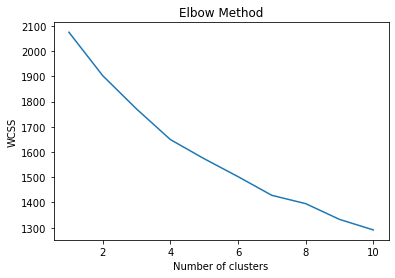

In [28]:
elbow_k(course_transformed, 'course_idx')

In [30]:
crs_clustered = cluster(course_transformed, 'course_idx')
crs_clustered.head()

course_idx  cluster_num  calculation_id   subject catalog  number_grade  \
0           0            2       2760.6500  linguist     103           4.0   
1           1            3       2760.6500   spanish     107           4.0   
2           1            3      14369.2000   spanish     107           4.0   
3           1            3      15731.7625   spanish     107           4.0   
4           1            3      17094.5625   spanish     107           4.0   

          major_1                      minor_1 minor_2  class_year  \
0  economics (bs)                          NaN     NaN           8   
1  economics (bs)                          NaN     NaN           5   
2  economics (bs)  Cultural Anthropology (MIN)     NaN           5   
3  economics (bs)                          NaN     NaN           5   
4  economics (bs)                          NaN     NaN           5   

   grade_normed  
0      0.036496  
1      0.036496  
2      0.037951  
3      0.033698  
4      0.037559

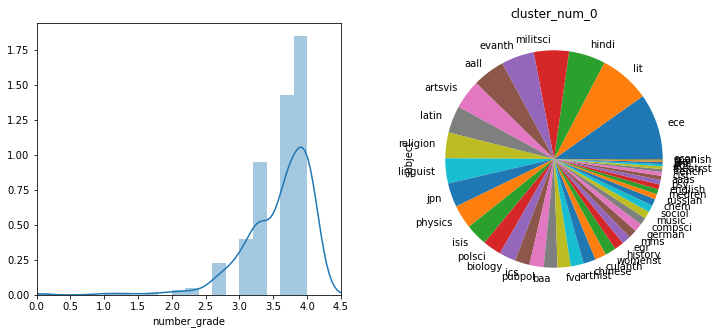

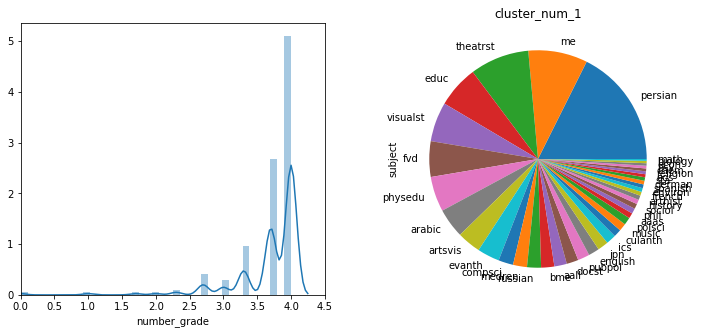

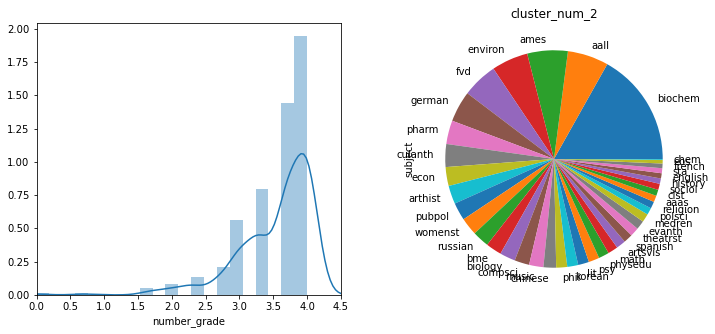

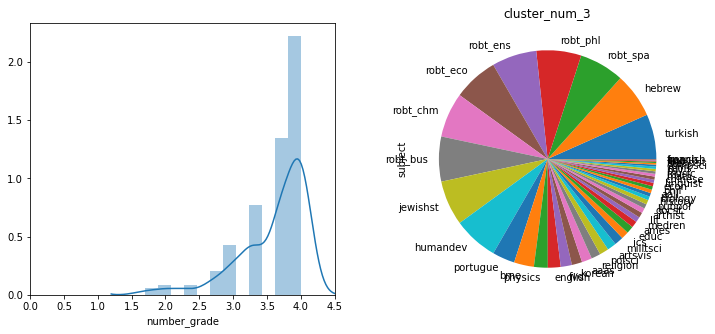

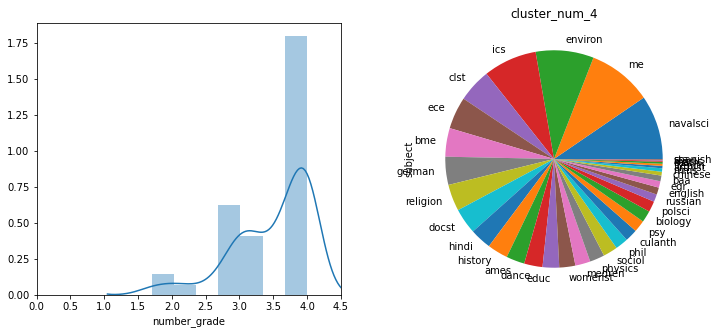

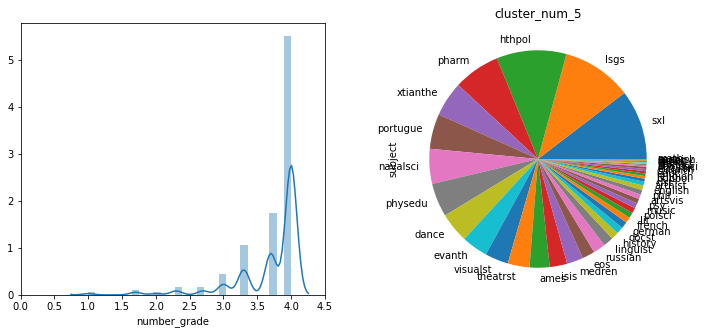

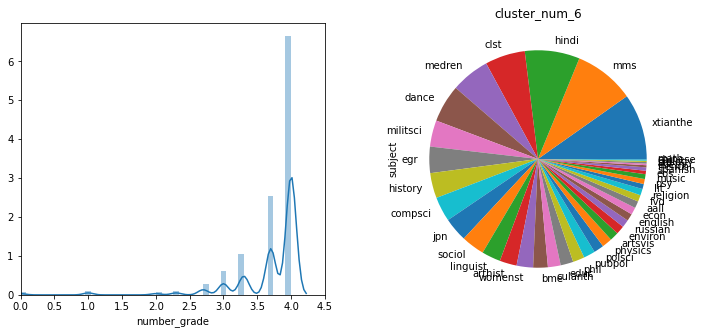

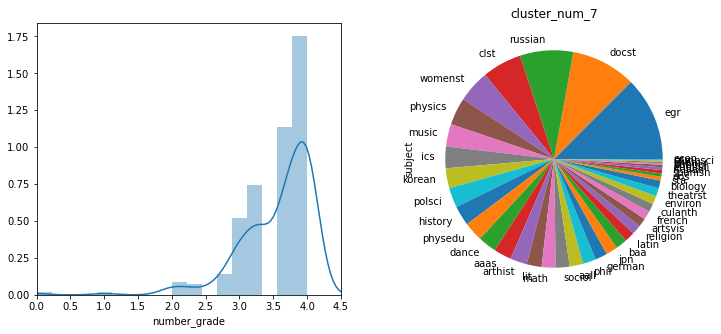

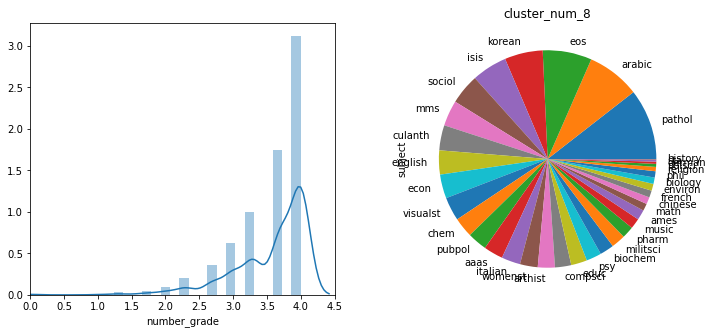

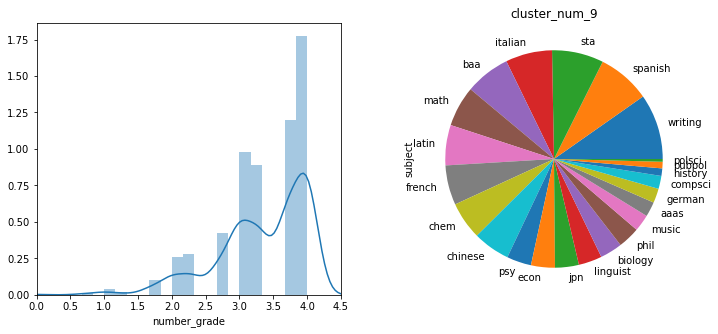

In [49]:
# plot the distribution of col within a cluster
def dist_within_crs_cluster(clustered, col1, col2, k):
    cluster_k = clustered[clustered['cluster_num'] == k]
    plt.subplot(1,2,1)
    sns.distplot(cluster_k[col1])
    plt.xlim(0,4.5)
    
    plt.subplot(1,2,2)
    dist =(cluster_k[col2].value_counts()/clustered[col2].value_counts()).reset_index().sort_values(col2, ascending=False)
    dist[col2].plot(kind='pie', labels=dist['index'])
    
    plt.title(f'cluster_num_{k}')
    #return dist

# check subject and maj/minor distribution within a cluster
for i in range(10):
    plt.figure(figsize=(12,5))
    dist_within_crs_cluster(clustered, 'number_grade', 'subject', i)    
    
    plt.show()

## Course Topic Modeling based on Years

In [68]:
import gensim.corpora as corpora
import gensim
from pprint import pprint
import pyLDAvis.gensim
import pickle 
import pyLDAvis

In [53]:
df['descr'] = df['descr'].str.replace(' ', '_')
grped = df.groupby(['calculation_id', 'class_year'])['descr'].apply(list).reset_index()
grped

calculation_id  class_year  \
0         15839.4125         1.0   
1         15839.4125         2.0   
2         15839.4125         3.0   
3         19857.1625         1.0   
4         19920.5375         1.0   
...              ...         ...   
8906      30330.9000         4.0   
8907      31205.5000         1.0   
8908      31205.5000         2.0   
8909      31205.5000         3.0   
8910      31205.5000         4.0   

                                                  descr  
0     [major_italian_authors, italian_lit_and_civ_(t...  
1     [intro_to_italian_lit_ii, selected_topics_in_e...  
2     [writing_workshop, adv_top__italian_lit/cultur...  
3     [non-canonical_gospels, abnormal_psychology, c...  
4     [intro_to_music_theory_(beg), prisoner's_dilem...  
...                                                 ...  
8906  [music/social_life/scenes, doc_exper:_a_video_...  
8907  [intermediate_finance, special_topics, social_...  
8908  [introduction_to_econometrics, medical_sociolo...  
8909  [corporate_finance, introduction_to_chemistry,...  
8910  [mental_health, special_topics_in_environment,...  

[8911 rows x 3 columns]

In [81]:
year1 = grped[grped['class_year']<=2]
year2 = grped[(grped['class_year']>=3) & (grped['class_year']<=4)]
year3 = grped[(grped['class_year']>=5) & (grped['class_year']<=6)]
year4 = grped[(grped['class_year']>=7) & (grped['class_year']<=8)]

year3

calculation_id  class_year  \
176       23398.7375         5.0   
177       23398.7375         6.0   
251       23564.8375         6.0   
526       24045.6125         5.0   
558       24070.3500         5.0   
...              ...         ...   
8890      30317.7500         5.0   
8891      30317.7500         6.0   
8896      30325.4875         5.0   
8901      30329.5500         5.0   
8902      30329.5500         6.0   

                                                  descr  
176   [corp._finance_theory, financial_mrkt_and_inve...  
177                                   [public_speaking]  
251   [forecasting_financial_markets, statistics, th...  
526   [public_speaking, corporate_finance, introduct...  
558   [honors_rsrch_independent_study, theoretical_f...  
...                                                 ...  
8890  [intermediate_macroeconomics, brains,_everywhe...  
8891  [special_topics_in_psychology, inside_hedge_fu...  
8896  [art_and_markets, women_in_visual_arts, explor...  
8901  [intermediate_microeconomics_ii, moments_in_bl...  
8902  [history_of_economic_thought, economics_of_edu...  

[1859 rows x 3 columns]

In [88]:
data_words = year2['descr']

# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [89]:
# number of topics
num_topics = 5

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.070*"intermediate_microeconomics_ii" + 0.046*"multivar_calculus_for_econ" '
  '+ 0.041*"intermediate_macroeconomics" + 0.028*"probability" + '
  '0.025*"intermediate_microeconomics_i" + '
  '0.022*"data_structures_and_algorithms" + '
  '0.021*"practical_financial_markets" + 0.019*"probability/stat_infer" + '
  '0.018*"introduction_to_econometrics" + 0.012*"intermediate_finance"'),
 (1,
  '0.061*"intermediate_microeconomics_i" + 0.041*"financial_accounting" + '
  '0.039*"prisoner\'s_dilemma/distr_justi" + '
  '0.037*"multivar_calculus_for_econ" + 0.034*"intermediate_finance" + '
  '0.029*"intermediate_microeconomics_ii" + 0.029*"probability" + '
  '0.019*"introduction_to_econometrics" + 0.019*"selected_topics_in_economics" '
  '+ 0.014*"intermediate_macroeconomics"'),
 (2,
  '0.087*"probability/stat_infer" + 0.043*"intermediate_microeconomics_ii" + '
  '0.030*"practical_financial_markets" + 0.026*"intermediate_microeconomics_i" '
  '+ 0.023*"financial_accounting" + 0.022*"inte

In [90]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.040449  0.000611       1        1  26.168612
0      0.057490 -0.074155       2        1  23.935505
2      0.015899  0.019337       3        1  20.828232
4      0.002931  0.085719       4        1  14.738986
3     -0.116770 -0.031513       5        1  14.328665, topic_info=                               Term        Freq       Total Category  logprob  \
144          probability/stat_infer  291.000000  291.000000  Default  30.0000   
87   prisoner's_dilemma/distr_justi  131.000000  131.000000  Default  29.0000   
64      intermediate_macroeconomics  172.000000  172.000000  Default  28.0000   
448   intermediate_microeconomics_i  369.000000  369.000000  Default  27.0000   
398           computer_architecture   50.000000   50.000000  Default  26.0000   
..                              ...         ...         ...      ...      ...   
30             intermediate_finance   11.944110  218.635300   Topic5  -4.7510   
125       intro_to_computer_science    7.954131   84.467178   Topic5  -5.1576   
90             chem/technol/society    6.954607   44.891132   Topic5  -5.2919   
17                   special_topics    6.959184   46.193764   Topic5  -5.2912   
611          laboratory_calculus_ii    6.981126   78.998184   Topic5  -5.2881   

     loglift  
144  30.0000  
87   29.0000  
64   28.0000  
448  27.0000  
398  26.0000  
..       ...  
30   -0.9643  
125  -0.4198  
90    0.0781  
17    0.0501  
611  -0.4833  

[373 rows x 6 columns], token_table=      Topic      Freq                      Term
term                                           
269       2  0.201380       acoustics_and_music
269       3  0.604140       acoustics_and_music
269       4  0.100690       acoustics_and_music
446       1  0.134592                    acting
446       2  0.067296                    acting
...     ...       ...                       ...
42        2  0.558314      women_in_the_economy
42        3  0.171789      women_in_the_economy
42        4  0.085894      women_in_the_economy
42        5  0.085894      women_in_the_economy
934       2  0.743267  world_war_ii/french_film

[685 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3, 5, 4])

- if looking at all 4-year combined, there is one major topic that appears to be more major-related
    - year2 (5 topics):  math, entrepreneurship, intermediate-level economics, finance, and interest 